In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
from IPython.display import display
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
import yfinance as yf
init_notebook_mode(connected=True)

In [2]:
start = '2017-01-01'
finish = '2022-05-25'

data = yf.download('AAPL', start, finish)[['Open', 'Close', 'High', 'Low']]
data = data.rename(columns = {'Open' : 'OPEN', 'Close' : 'CLOSE', 'High' : 'HIGH', 'Low' : 'LOW'})

#data = web.DataReader('sber', 'moex', start=start, end=finish)[["OPEN", "CLOSE", "HIGH", "LOW"]]

data.tail()

[*********************100%***********************]  1 of 1 completed


,OPEN,CLOSE,HIGH,LOW
Date,,,,
2022-05-18,146.850006,140.820007,147.360001,139.899994
2022-05-19,139.880005,137.350006,141.660004,136.600006
2022-05-20,139.089996,137.589996,140.699997,132.610001
2022-05-23,137.789993,143.110001,143.259995,137.649994
2022-05-24,140.809998,140.360001,141.970001,137.330002


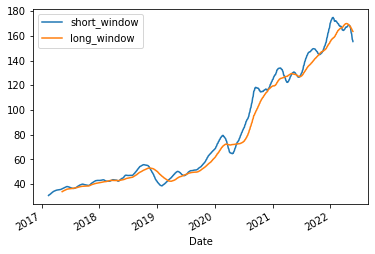

In [3]:
#скользящие
short_window = data["CLOSE"].rolling(30).mean()
long_window = data["CLOSE"].rolling(90).mean()

result=pd.concat([short_window, long_window],axis=1)
result.columns=['short_window', 'long_window']
data['short_window'] = short_window
data['long_window'] = long_window

data[['short_window', 'long_window']].plot()

data1 = data.reset_index()
data1 = data1.rename(columns = {'Date' : 'TRADEDATE'})
data1['TRADEDATE'] = data1['TRADEDATE'].dt.date

In [4]:
def robot(data1):
    money = 100000
    iznachalno = money
    stop_loss = 7
    number = 0 #тут будем хранить кол-во купленных акций
    m = 0 #это для перемещения по строкам
    price = 0 #для фиксирования цены, от которой будем считать stop_loss
    #создаем пустой фрейм
    new = pd.DataFrame(columns=(['date', 'signal', 'num_shares', 'share_value', 'share_price', 'rest', 'cash']), index = (range(0,50)))

    for i in range(0, data1.shape[0]):
        #тут sig_buy и buy
        if ((data1['short_window'][i] > data1['long_window'][i]) and (data1['short_window'][i-1] <= data1['long_window'][i-1])):
            new['date'][m] = data1['TRADEDATE'][i]
            new['signal'][m] = 'sig_buy'
            new['num_shares'][m] = 0
            new['share_value'][m] = data1["CLOSE"][i]
            new['rest'][m] = 0
            new['cash'][m] = money
            m+=1
            new['date'][m] = data1["TRADEDATE"][i+1]
            new['signal'][m] = 'buy'
            new['num_shares'][m] = money // data1["OPEN"][i+1]
            new['share_value'][m] = data1["OPEN"][i+1]
            new['share_price'][m] = new['num_shares'][m] * new['share_value'][m]
            new['rest'][m] = money - new['share_price'][m]
            new['cash'][m] = new['rest'][m]
            money = new['cash'][m]
            number = new['num_shares'][m]
            price = new['share_value'][m]
            m+=1
        #тут stop_loss на случай, если цена сильно упадет в день покупки
            if ((data1['LOW'][i] <= price*(1-0.01*stop_loss)) or (data1['OPEN'][i] <= price*(1-0.01*stop_loss))) and (new["signal"][m-1] == 'buy'):
                new['date'][m] = data1["TRADEDATE"][i]
                new['signal'][m] = 'stop_loss'
                new['num_shares'][m] = number
                new['share_value'][m] = price*(1-0.01*stop_loss)
                new['share_price'][m] = new['num_shares'][m] * new['share_value'][m]
                new['rest'][m] = money
                new['cash'][m] = new['share_price'][m] + new['rest'][m]
                money = new['cash'][m]
                number = 0
                m+=1
        #тут sig_sale и sale
        if ((data1['short_window'][i] < data1['long_window'][i]) and (data1['short_window'][i-1] >= data1['long_window'][i-1]) and (number != 0)):
            new['date'][m] = data1["TRADEDATE"][i]
            new['signal'][m] = 'sig_sale'
            new['num_shares'][m] = number
            new['share_value'][m] = data1["CLOSE"][i]
            new['rest'][m] = money
            new['cash'][m] = money
            m+=1
            new['date'][m] = data1["TRADEDATE"][i+1]
            new['signal'][m] = 'sale'
            new['num_shares'][m] = number
            new['share_value'][m] = data1["OPEN"][i+1]
            new['share_price'][m] = new['num_shares'][m] * new['share_value'][m]
            new['rest'][m] = money
            new['cash'][m] = new['share_price'][m] + new['rest'][m]
            money = new['cash'][m]
            number = 0   
            m+=1
        #тут stop_loss
        if ((data1['LOW'][i] <= price*(1-0.01*stop_loss)) or (data1['OPEN'][i] <= price*(1-0.01*stop_loss))) and (new["signal"][m-1] == 'buy'):
            new['date'][m] = data1["TRADEDATE"][i]
            new['signal'][m] = 'stop_loss'
            new['num_shares'][m] = number
            new['share_value'][m] = price*(1-0.01*stop_loss)
            new['share_price'][m] = new['num_shares'][m] * new['share_value'][m]
            new['rest'][m] = money
            new['cash'][m] = new['share_price'][m] + new['rest'][m]
            money = new['cash'][m]
            number = 0
            m+=1
    if (new['signal'][m-1] == 'sale') or (new['signal'][m-1] == 'stop_loss'):
        print('Было денег', iznachalno, ', a cтало денег -', round(new['cash'][m-1], 2))
        print('Процент прироста изначальных вложений составил', round((new['cash'][m-1]-iznachalno)/iznachalno*100, 2), '%')
    if (new['signal'][m-1] == 'buy'):
        print('Было денег', iznachalno, ', a cтало денег -', round(new['cash'][m-3], 2))
        print('Процент прироста изначальных вложений составил', round((new['cash'][m-3]-iznachalno)/iznachalno*100, 2), '%')
    return(new[new['signal'].isna() == False])

In [5]:
gotovo = robot(data1)
gotovo['date'] = pd.to_datetime(gotovo['date'])
display(gotovo)

Было денег 100000 , a cтало денег - 187160.79
Процент прироста изначальных вложений составил 87.16 %


,date,signal,num_shares,share_value,share_price,rest,cash
0,2017-08-03,sig_buy,0,38.892502,NaN,0,100000
1,2017-08-04,buy,2562.0,39.017502,99962.839691,37.160309,37.160309
2,2018-02-22,sig_sale,2562.0,43.125,NaN,37.160309,37.160309
3,2018-02-23,sale,2562.0,43.4175,111235.633827,37.160309,111272.794136
4,2018-03-20,sig_buy,0,43.810001,NaN,0,111272.794136
5,2018-03-21,buy,2542.0,43.759998,111237.915733,34.878403,34.878403
6,2018-04-24,sig_sale,2542.0,40.735001,NaN,34.878403,34.878403
7,2018-04-25,sale,2542.0,40.654999,103345.006897,34.878403,103379.8853
8,2018-05-10,sig_buy,0,47.509998,NaN,0,103379.8853
9,2018-05-11,buy,2182.0,47.372501,103366.797997,13.087303,13.087303


In [6]:
fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Ohlc(x=data1['TRADEDATE'],
                            open=data1['OPEN'],
                            high=data1['HIGH'],
                            low=data1['LOW'],
                            close=data1['CLOSE'], name="price", 
                            increasing_line_color= 'forestgreen', decreasing_line_color= 'brown'))

fig.add_trace(go.Scatter(
    x=data1["TRADEDATE"], y=data1['short_window'],
    mode="lines",
    name="short_window", line_color = 'coral'))

fig.add_trace(go.Scatter(
    x=data1["TRADEDATE"], y=data1['long_window'],
    mode="lines",
    name="long_window", line_color = 'cornflowerblue'))

fig.add_trace(go.Scatter(
    x=gotovo[gotovo['signal'] == 'sig_buy']['date'],
    y=gotovo[gotovo['signal'] == 'sig_buy']['share_value'], mode='markers', marker_symbol = 'triangle-up',
    marker=dict(size=15, color='green'), name="sig_buy"))

fig.add_trace(go.Scatter(
    x=gotovo[gotovo['signal'] == 'sig_sale']['date'],
    y=gotovo[gotovo['signal'] == 'sig_sale']['share_value'], mode='markers',  marker_symbol = 'triangle-down',
    marker=dict(size=15, color='red'), name="sig_sale"))

fig.add_trace(go.Scatter(
    x=gotovo[gotovo['signal'] == 'stop_loss']['date'],
    y=gotovo[gotovo['signal'] == 'stop_loss']['share_value'], mode='markers', marker_symbol = 'triangle-down',
    marker=dict(size=15, color='black'), name="stop_loss"))

fig.add_trace(go.Scatter(x = data1['TRADEDATE'], y = np.where(data1['short_window'] > data1['long_window'], 1, 0), 
                         name="grafic", line_color = 'black'), row = 3, col = 1)

fig.show()